# COGS 189 FINAL PROJECT

By: Matthew Morgan


Team Name: N-art

## Introduction and Motivation

This main goal of this project is to use EEG-Art visualization techniques to visualize EEG data in a pleasing manner. This is useful for displaying EEG data in a user-friendly environment such as indicating attention spans in a class setting or displaying emotional states of mind for users who can not signal emotional states. It is important to convey these states of mind for better studies on how to foster attention, and also having the ability to convey emotions without physical ques. 

This project will mainly focus on meditation data combined with attention and eeg data. 

## Data description

This project will mainly focus on meditation data combined with attention and eeg data. The data includes attention, meditation, and raw EEG data. Participants listened to 120 seconds of a song and their eeg, attention, and meditation EEG data was recorded for each song. The songs are (in order of ID): Fur Elise, Show&Tell, Boot Scootin Boogie, and Mo Bamba. 
They listened to the same 120 seconds of each song again but for each 10 second segment of the song, they were asked to record their emotion (Relaxed/0 or Energized/1).

<br>Data was sampled 128 times per second for 120 seconds resulting in 15,360 samples per song.
<br>Fs = 128
<br>dt = 1./Fs 
<br>Max time = 120

Credits to Lulu Ricketts, Catherine Wang, Vicky Vo (Team musicEEGart) for collecting and providing the data!

## Related Work

EEGNET: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0138297
<br> Neurosky Apps: http://neurosky.com/2015/11/beautiful-brainwaves-creating-eeg-art/
<br> Numpy art: https://medium.com/@patrickbfuller/numpy-art-a-tutorial-in-scatter-fun-634f79628435
<br> Perlin noise: https://pypi.org/project/perlin-noise/#description
<br> Color Selection: https://www.designhill.com/design-blog/use-warm-cool-colors-logo-design/
<br> Dynamically animate graphs: https://medium.com/intel-student-ambassadors/live-graph-simulation-using-python-matplotlib-and-pandas-30ea4e50f883
<br> matplotlib animation: https://stackoverflow.com/questions/39658717/plot-dynamically-changing-graph-using-matplotlib-in-jupyter-notebook
<br> point formatting: https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html

## Methods

EEG data to art processing code:

In [184]:
%matplotlib notebook

#data vis esentials
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#animating graphs
from matplotlib.animation import FuncAnimation
from mpl_toolkits import mplot3d

from random import randrange
from threading import Thread
import time

#for data manipulating from files
import json
import os
import glob
import pprint

#filtering/processing imports:                   
import matplotlib.patches as patches
import scipy.signal as signal
from scipy.signal import butter, sosfilt, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from pathlib import Path

plt.style.use('dark_background')

x: 
12536


<IPython.core.display.Javascript object>


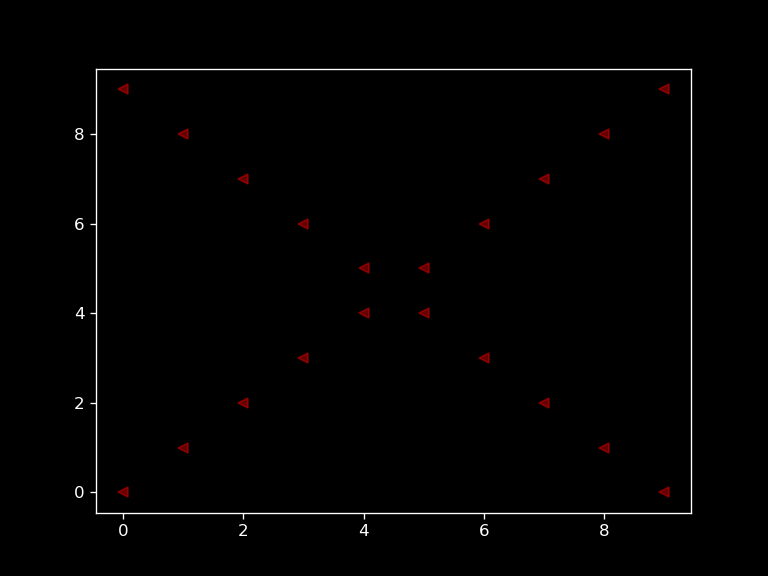

x: 
12847
x: 
3614
x: 
430
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [185]:
#test graphing
Fs = 128
f = 20
sample = 20
y = [0,1,2,3,4,5,6,7,8,9,9,8,7,6,5,4,3,2,1,0]
x = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
plt.plot(x, y,'r<', alpha=0.4)
#len(y)
print(x)
y

<IPython.core.display.Javascript object>


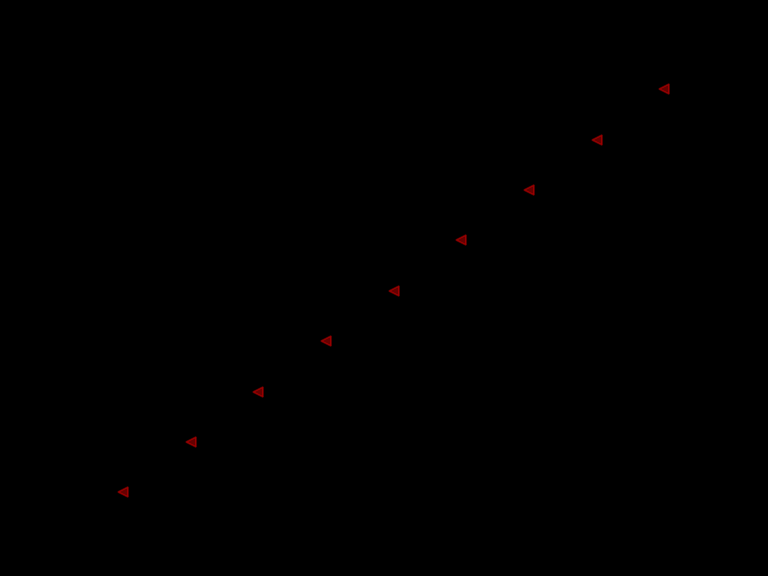

In [186]:
#test animating graphs:
Fs = 128
f = 10
sample = 100



Fs = 128
f = 20
sample = 100
#x = np.arange(sample)
#y = np.sin(2 * np.pi * f * x / Fs)
x = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
y = [0,1,2,3,4,5,6,7,8,9,9,8,7,6,5,4,3,2,1,0]

class LiveGraph:
    def __init__(self):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        plt.axis('off')
        self.line, = plt.plot(self.x_data, self.y_data,'r<', alpha=0.4)
        #plt.scatter(a,b, alpha=0.4, marker=marker,
                                                                    #color=color, s=size)
        #change interval to increase update time
        self.animation = FuncAnimation(self.figure, self.update, interval=200)
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def update(self, frame):
        self.line.set_data(self.x_data, self.y_data)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        return self.line,

    def show(self):
        plt.show()

    def thread_f(self):
        j = 0
        #x = np.arange(sample)
        #y = np.sin(2 * np.pi * f * x / Fs)
        #x1 = x[i]
        #y1 = y[i]
        while True:
            self.x_data.append(x[j])
            self.y_data.append(y[j])   
            j += 1
            #match with interval to change update time
            time.sleep(.2)  

g = LiveGraph()
g.show()

#plt.plot(x, y)
#plt.show()

In [187]:
#import json EEG data and store in a dictionary of dataframes
path = './musicEEGart/DataCollection/data/eeg_data'
samples = {}
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.  
    fname = filename
    filename = filename.split('/')
    filename = filename[5]
    filename = filename.split('.')
    filename = filename[0]
    samples[filename] = pd.read_json(fname)

samples['user1song1']['raw_eeg']
#samples['user1song1']['meditation']
data1 = samples['user1song1']['raw_eeg']
#data1

<IPython.core.display.Javascript object>


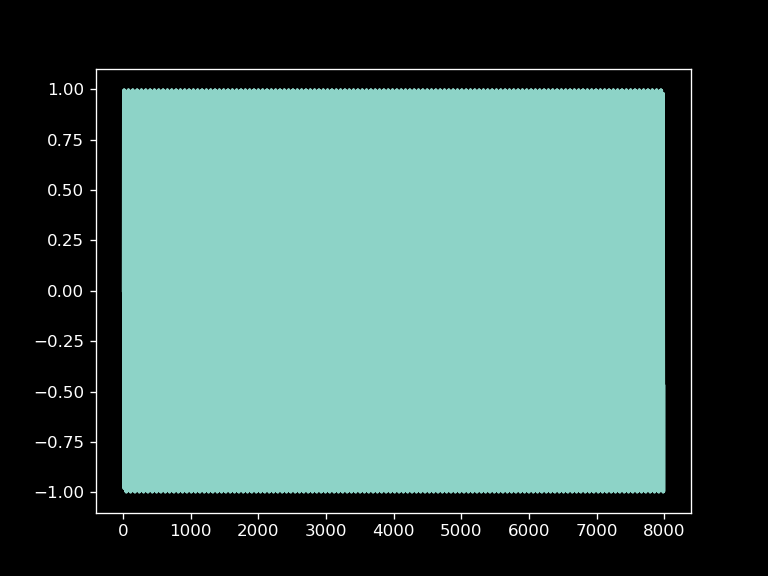

In [188]:
#filtering Proof of Concept:
Fs = 128
f = 10
sample = 8000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
plt.plot(x, y)
plt.show()

<IPython.core.display.Javascript object>


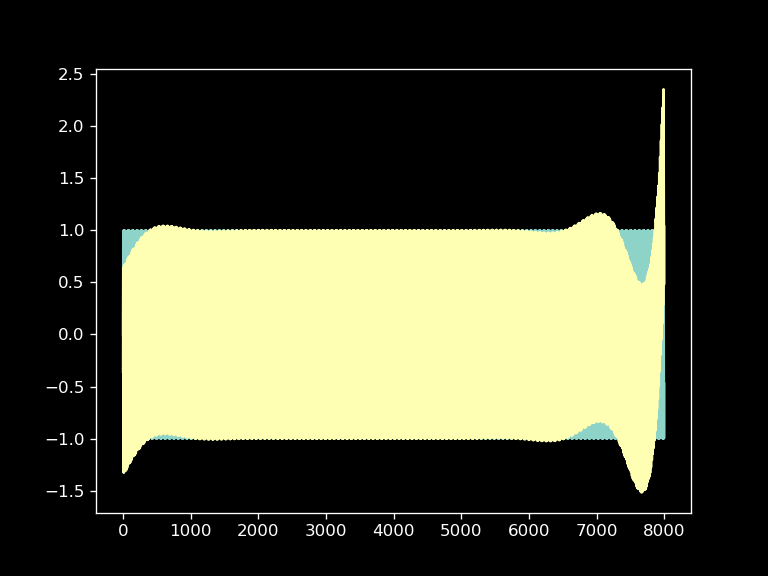

In [189]:
#filter data (proof of concept):
plt.style.use('dark_background')
# Define our filter variables
fs = 128.0                      # Hz; sampling rate
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 45                      # Hz; our high cut for our bandpass
order = 3                       # filter order (functionally doubled)


# Create our filter coefficient as as a second-order section
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

#dict of filtered EEG data for all samples
filterTest = sosfiltfilt(sos, y)

plt.plot(np.arange(0,sample), y)
plt.show()
plt.plot(np.arange(0,sample), filterTest)
plt.show()


<IPython.core.display.Javascript object>


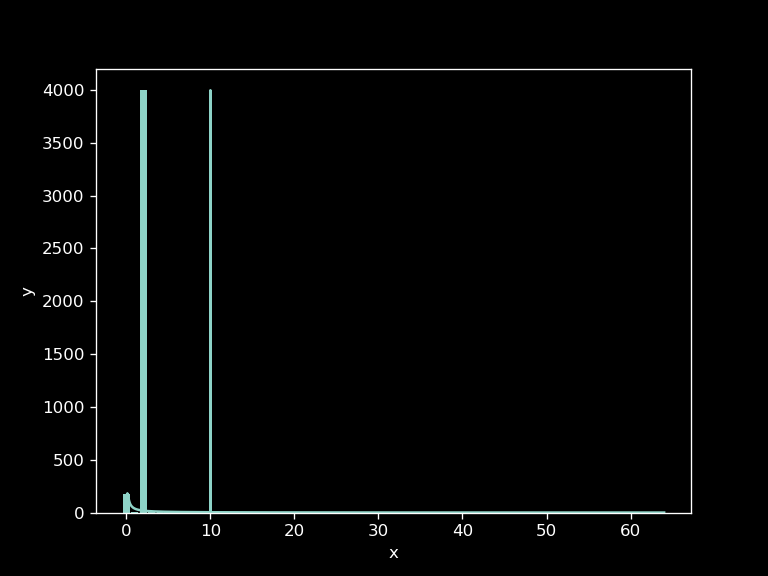

In [190]:
#extract EEG bands proof of concept
fs = 128
eeg_bands  = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
data = filterTest
fft_vals = np.absolute(np.fft.rfft(data))
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)
# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.max(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
plt.plot(fft_freq, fft_vals)
plt.show()
plt.bar(range(5),df['val'])
#plt.xticks([0,1,2,3,4],['delta','theta','alpha','beta', 'gamma'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<IPython.core.display.Javascript object>


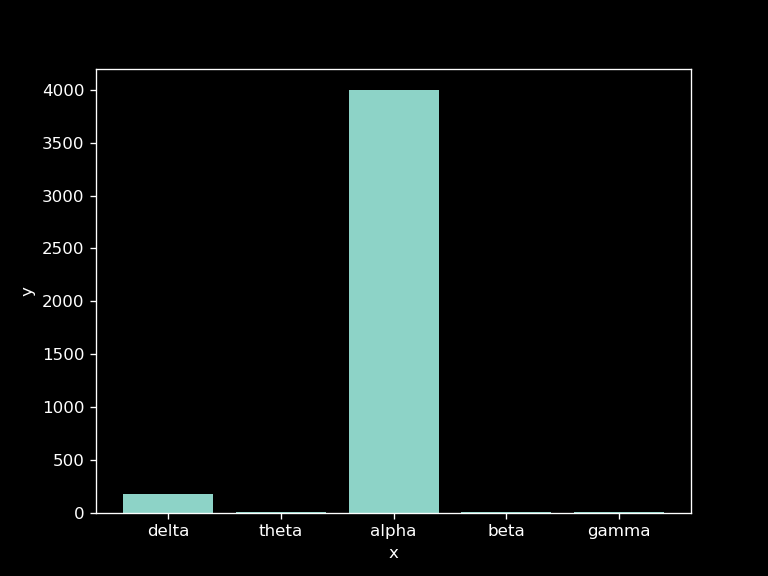

In [191]:
#extract EEG bands proof of concept

x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
eeg_bands  = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
data = filterTest
fft_vals = np.absolute(np.fft.rfft(data))
# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)
# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.max(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
plt.bar(range(5),df['val'])
plt.xticks([0,1,2,3,4],['delta','theta','alpha','beta', 'gamma'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

<IPython.core.display.Javascript object>


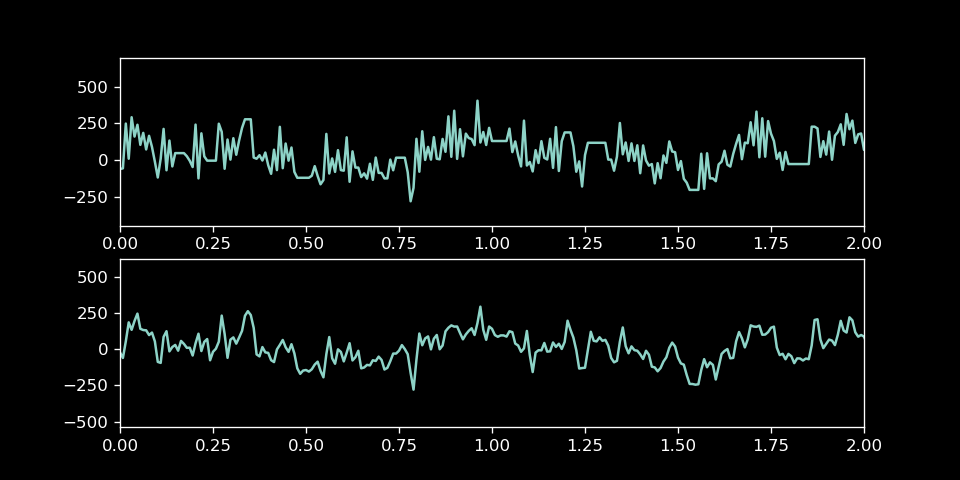

In [192]:
#filter real EEG data:
plt.style.use('dark_background')
# Define our filter variables
fs = 128.0                      # Hz; sampling rate
#dt = 1000/fs                    # ms; time between samples
#sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
hp = 0.1                        # Hz; our low cut for our bandpass
lp = 45                      # Hz; our high cut for our bandpass
order = 3                       # filter order (functionally doubled)

# Create our filter coefficient as as a second-order section
sos = butter(order, [hp, lp], analog = False, btype = 'band', output = 'sos', fs = fs)

#dict of filtered EEG data for all samples
filteredSamples = {}

#filtering the data:
for k,v in samples.items():
    data1 = samples[k]['raw_eeg']
    filteredEEG = sosfilt(sos, samples[k]['raw_eeg'])
    filteredSamples[k] = filteredEEG
    #fig,ax = plt.subplots(2,1, figsize=(12,6))

fig,ax = plt.subplots(2,1, figsize=(8,4))
ax[0].plot(np.arange(0,120,1/fs), samples['user2song1']['raw_eeg'])
ax[0].set_xlim([0,2])
ax[1].plot(np.arange(0,120,1/fs), filteredSamples['user2song1'])

ax[1].set_xlim([0,2])
plt.show()
#example of first sample (top graph is filtered, bottom is unfiltered)

<IPython.core.display.Javascript object>


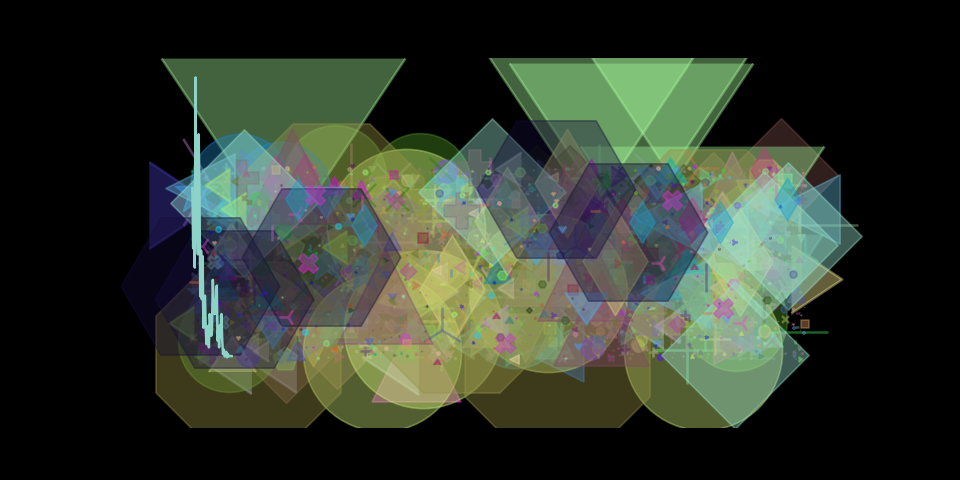

51
51
{'Delta': 887.6947844386068, 'Theta': 1460.7273597343647, 'Alpha': 1166.6310200494781, 'Beta': 564.2844854614411, 'Gamma': 413.21999232937327}
Theta


'Theta'

In [227]:
#test extract real EEG bands
fig, ax = plt.subplots(figsize=(8, 4))

eeg_bands  = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
k = 3000
m = 3100
data = filteredSamples['user5song1'][k:m]
fft_vals = np.absolute(np.fft.rfft(data))
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.max(fft_vals[freq_ix])
ax.plot(fft_freq, fft_vals)

print(len(fft_freq))
print(len(fft_vals))
print(eeg_band_fft)
print(max(eeg_band_fft, key=eeg_band_fft.get))
mm = max(eeg_band_fft, key=eeg_band_fft.get)
mm


<IPython.core.display.Javascript object>


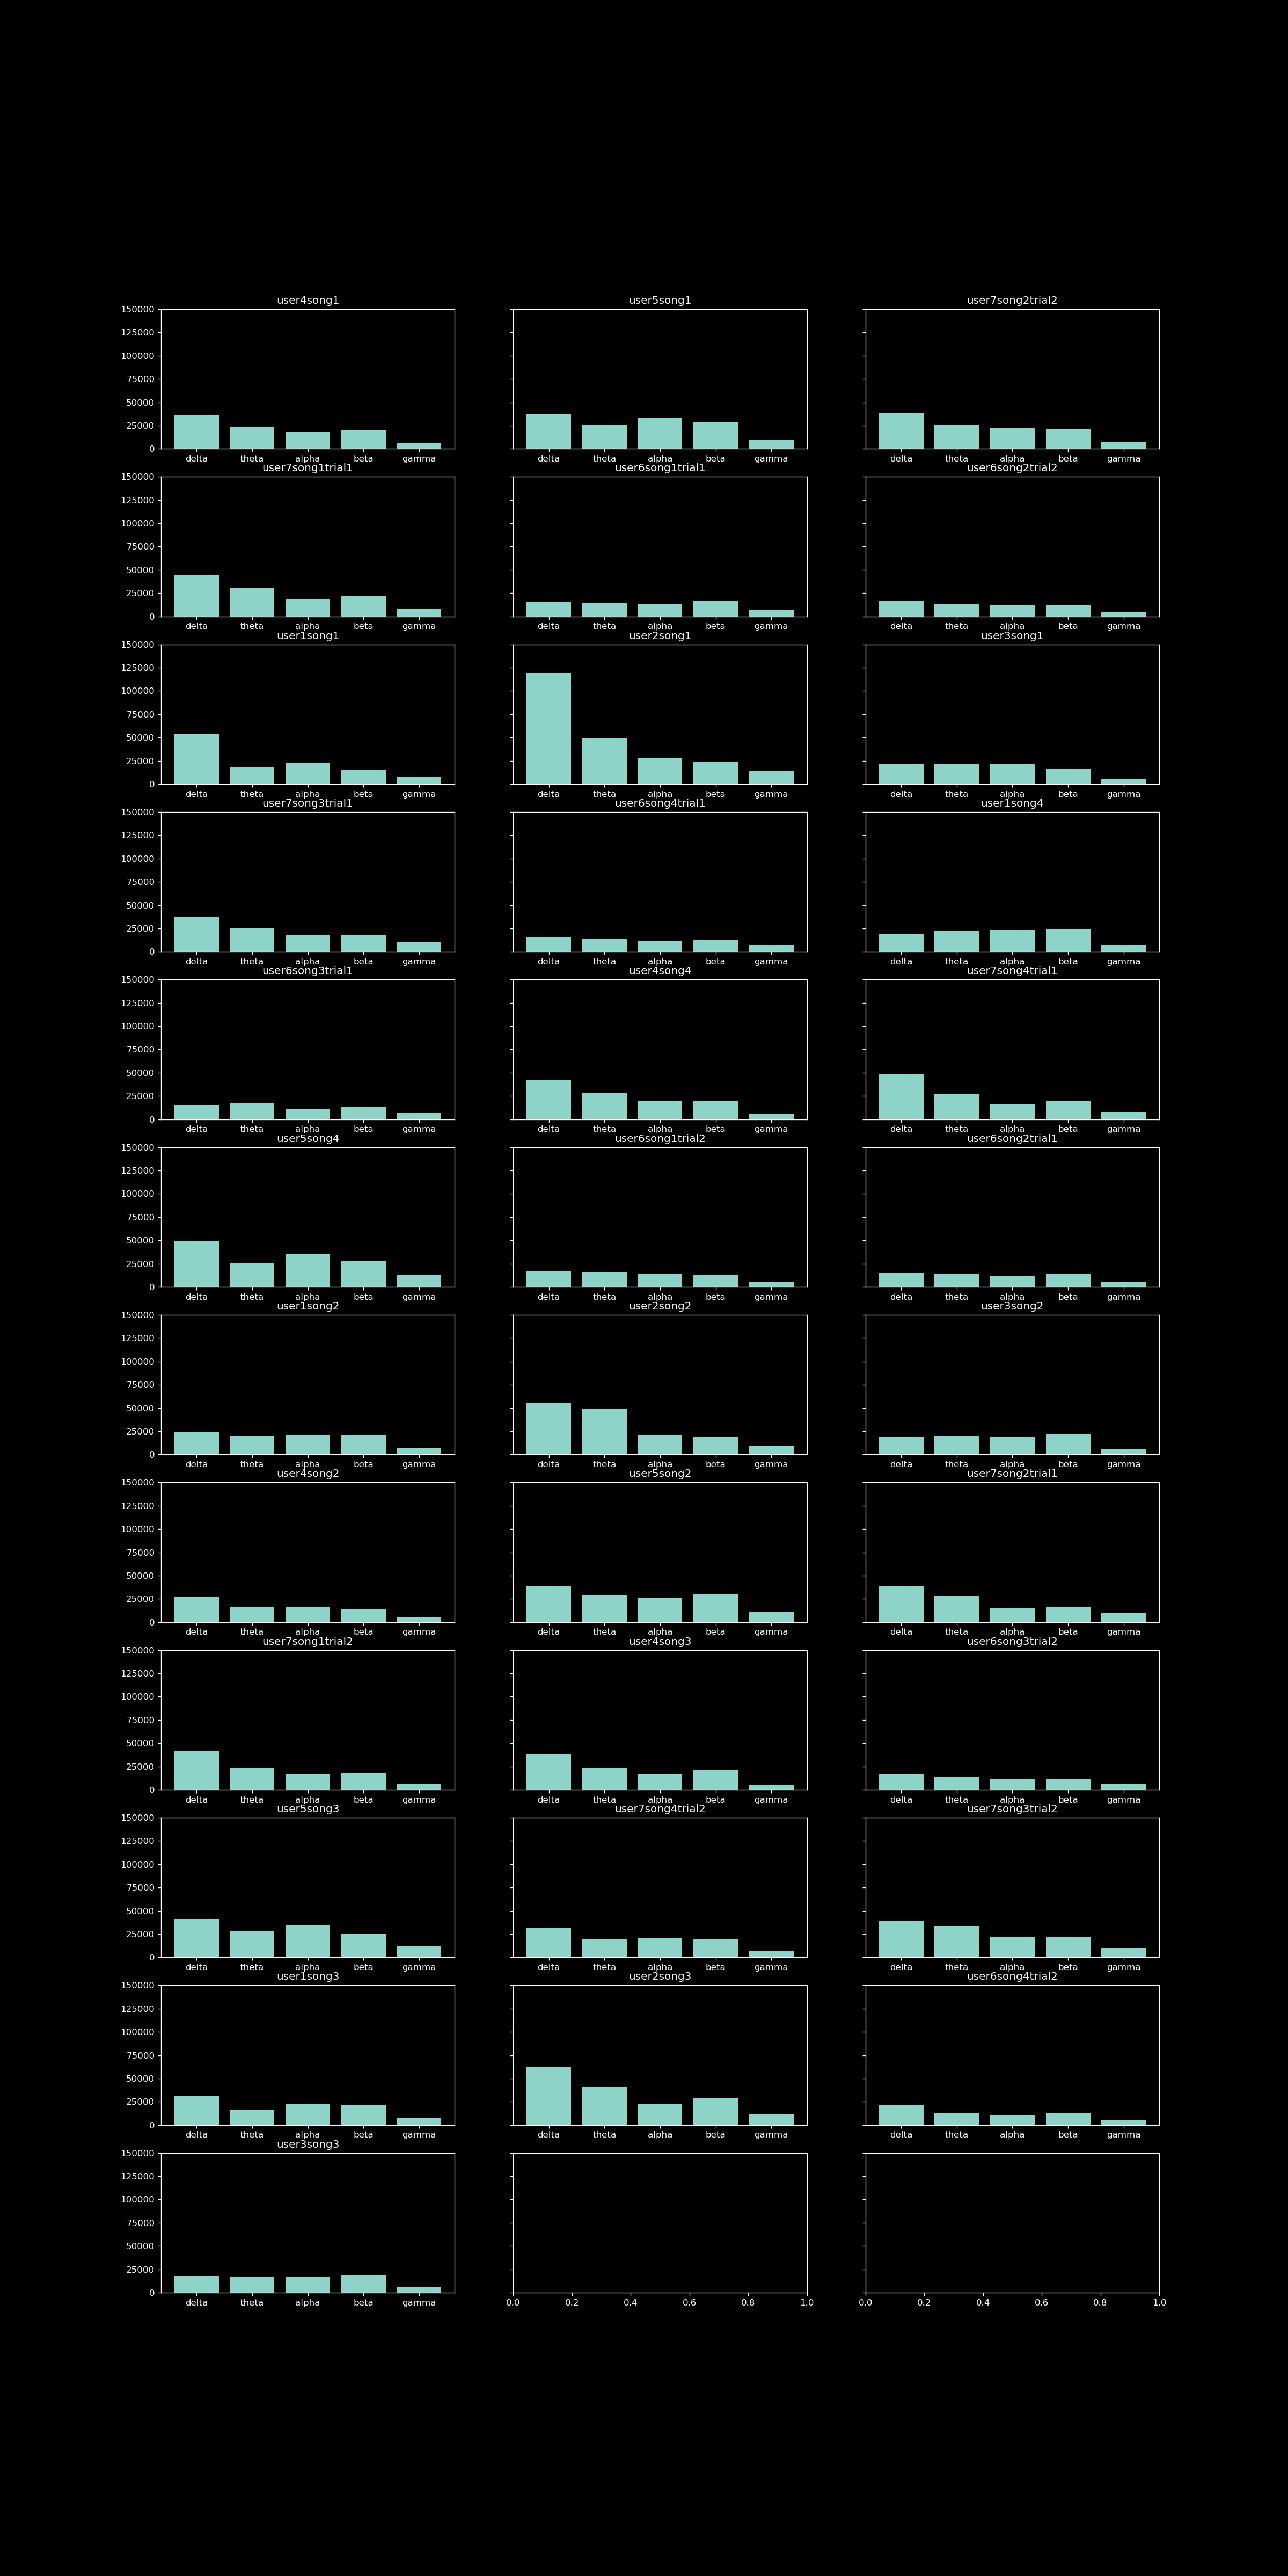

In [194]:
#extract real features (bands)
fig,ax = plt.subplots(12,3, figsize=(20,40), sharey=True)
fs = 128
eeg_bands  = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

count = 0
EEGbands = {}
eegforvis = {}

for k,v in filteredSamples.items():
    data = filteredSamples[k]
#for k,v in samples.items():
 #   data = samples[k]['raw_eeg']
    fft_vals = np.absolute(np.fft.rfft(data))
    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)
    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.max(fft_vals[freq_ix])

    # Plot the data (using pandas here cause it's easy)
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    EEGbands[k] = df
    ax[int(count/3),(count % 3)].bar(range(5),df['val'])#.bar(range(4), df'val', title=k, legend=False)
    ax[int(count/3),count%3].set_xticklabels([0,'delta','theta','alpha','beta', 'gamma'])
    ax[int(count/3),count%3].set_title(k)
    ax[int(count/3),count%3].set_ylim([0,150000])
    #ax[count].set_xlabel("EEG band")
    #ax[count].set_ylabel("band Amplitude")
    #plt.plot(fft_freq, fft_vals)
    count += 1
    
    
#Credits to https://dsp.stackexchange.com/questions/45345/how-to-correctly-compute-the-eeg-frequency-bands-with-python


In [174]:
#EEGbands

In [195]:
#creating variables to visualize the data

#color scheme:
coolColors = 0
warmColors = 0
#point shapes:
circleShape = 'circle'

#opaqcity:


#background color:



x: 
239


<IPython.core.display.Javascript object>


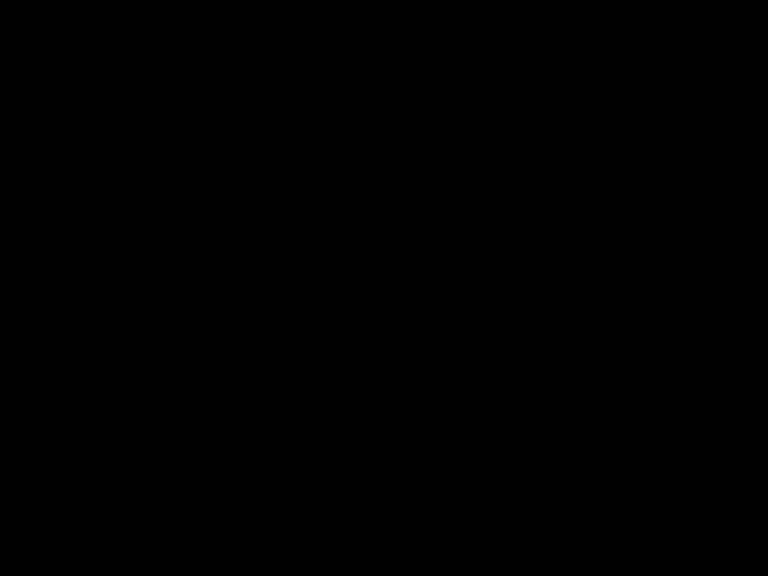

In [198]:
#test animate with color
markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', 
           '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', 
           '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 
           'H': 'hexagon2', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', 
           '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 
           3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase',
           9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', 
           ' ': 'nothing', '': 'nothing'}
#plt.axis('off')
#plt.style.use('dark_background')
colors = {'red':'r', 'green':'g', 'blue':'b'}
x = np.array([])
y = np.array([])
for _ in range(1000):
    x = np.append(x, np.random.randint(0,100,5))
    y = np.append(y, np.random.randint(0,100,5))
    rgba = [np.random.random() for _ in range(4)]
    color = np.array([rgba])
    marker = np.random.choice(list(markers.keys()))
    alpha = np.random.random()**2.5
    size = np.random.exponential()**5.3

#y = [0,1,2,3,4,5,6,7,8,9,9,8,7,6,5,4,3,2,1,0]
#x = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]

j = 0
k = 0
currBand = "Delta"
class LiveGraph:
    def __init__(self):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        #ax = fig.add_subplot(111)
        #plt.ion()
        plt.axis('off')
        #rgba = [np.random.random() for _ in range(4)]
        #color = np.array([rgba])
        marker = np.random.choice(list(markers.keys()))
        #alpha = np.random.random()**2.5
        size = np.random.randint(0,100)#np.random.exponential()**5.3        
        self.line, = plt.plot(self.x_data, self.y_data,'ro',alpha=0.4, ms=size)
        
        #plt.scatter(a,b, alpha=0.4, marker=marker,
                                                                    #color=color, s=size)
        self.animation = FuncAnimation(self.figure, self.update, interval=5)
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def update(self, frame):
        
        k += 1
        if (k > 100):
            k = 0
        
        
        size = np.random.randint(10,70)
        self.line.set_data(self.x_data, self.y_data)
        self.line.set_markersize(size)
        #rgba = [np.random.random() for _ in range(4)]
        #color = np.array([rgba])
        color = np.random.choice(list(colors.keys()))
        self.line.set_markerfacecoloralt(color)
        self.line.set_markerfacecolor(color)
        #self.line.update_from(self.line, otherFig.line)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        return self.line,

    def show(self):
        
        plt.show()

    def thread_f(self):
        
        j=0
        while True:
            if j > len(x):
                print("x: ")
                print(j)
                break
            if j > len(y):
                print("y: ")
                print(j)
                break
            self.x_data.append(x[j])
            self.y_data.append(y[j])
            #self.x_data = x[j]
            #self.y_data = y[j]
            j += 1
            
            time.sleep(.05)  
    
g = LiveGraph()
g.show()
#print(x)
#print(y)

In [103]:
len(samples['user1song1']['attention'].unique())

45

In [111]:
color = (1,0,1,1)
color

(1, 0, 1, 1)

<IPython.core.display.Javascript object>


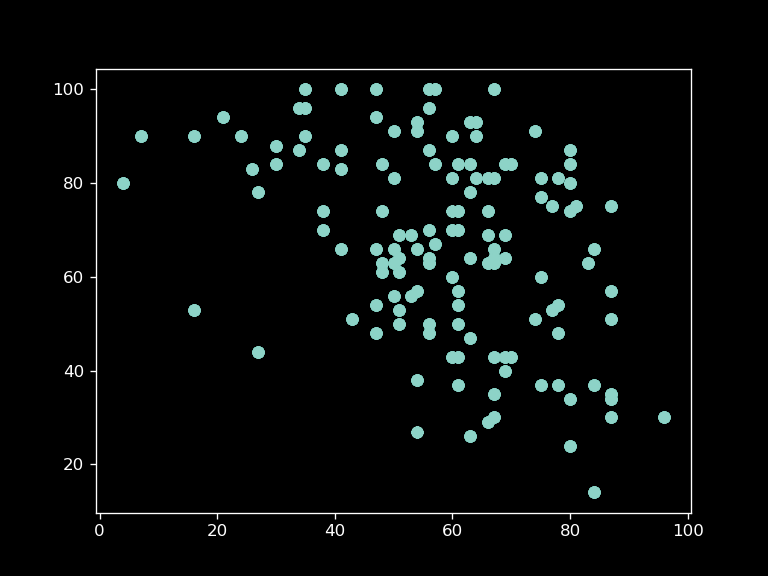

In [136]:
#weak negative correlation = basically no correlation
x = np.arange(0,15360)
x= samples['user1song1']['meditation']
y = samples['user1song1']['attention']
plt.plot(x,y, 'o')

<IPython.core.display.Javascript object>


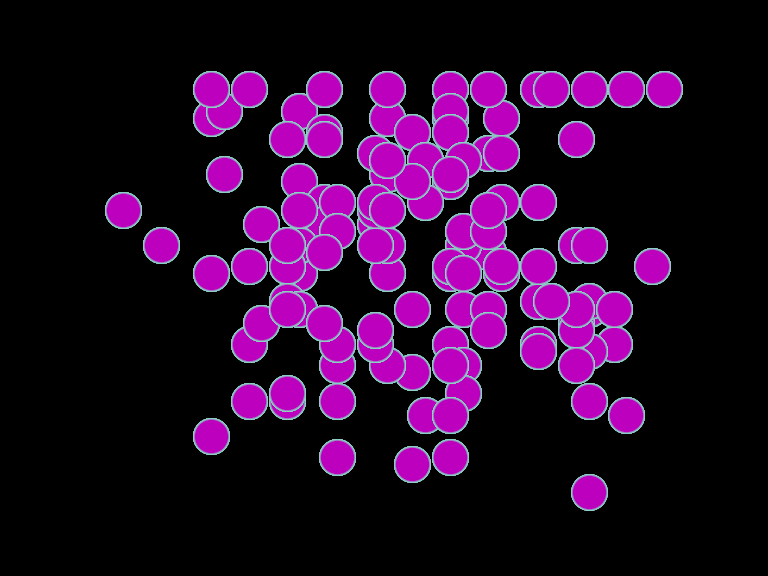

In [235]:
#the real visualization goal code:

markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', 
           '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', 
           '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 
           'H': 'hexagon2', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', 
           '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 
           3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase',
           9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', 
           ' ': 'nothing', '': 'nothing'}
#plt.axis('off')
#plt.style.use('dark_background')

eeg_bands  = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

colors = {'Theta':'g', 'Delta':'b', 'Alpha':'m','Beta':'c', 'Gamma':'y'}

#data = filteredSamples (EEG)
#using sample user1song1
x = samples['user5song1']['attention']
y = samples['user5song1']['meditation']
#y = [0,1,2,3,4,5,6,7,8,9,9,8,7,6,5,4,3,2,1,0]
#x = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]
j = 0
k = 0
m = 300
class LiveGraph:
    def __init__(self):
        self.x_data, self.y_data = [], []
        self.figure = plt.figure()
        plt.axis('off')
        marker = np.random.choice(list(markers.keys()))
        #alpha = np.random.random()**2.5
        size = np.random.randint(0,250)#np.random.exponential()**5.3        
        self.line, = plt.plot(self.x_data, self.y_data,'o',alpha=0.4, ms=size)
        
        #plt.scatter(a,b, alpha=0.4, marker=marker,
                                                                    #color=color, s=size)
        self.animation = FuncAnimation(self.figure, self.update, interval=500)
        self.th = Thread(target=self.thread_f, daemon=True)
        self.th.start()

    def update(self, frame):
        #if (m > 15358):
         #   return self.line
        
        data = filteredSamples['user5song1'][k:m]
        fft_vals = np.absolute(np.fft.rfft(data))
        fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)
        eeg_band_fft = dict()
        for band in eeg_bands:  
            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                               (fft_freq <= eeg_bands[band][1]))[0]
            eeg_band_fft[band] = np.max(fft_vals[freq_ix])

        maxband = max(eeg_band_fft, key=eeg_band_fft.get)
        
        size = np.random.randint(10,25)
        self.line.set_data(self.x_data, self.y_data)
        self.line.set_markersize(size)
        
        color = colors[maxband]
        #self.line.set_markerfacecoloralt(color)
        self.line.set_markerfacecolor(color)
        self.line.set_alpha(.4)
        #self.line.update_from(self.line, otherFig.line)
        self.figure.gca().relim()
        self.figure.gca().autoscale_view()
        return self.line,

    def show(self):
        
        plt.show()

    def thread_f(self):
        k=0
        m=0
        j=0
        while True:
            if j > len(x):
                print("x: ")
                print(j)
                break
            if j > len(y):
                print("y: ")
                print(j)
                break
            self.x_data.append(x[j])
            self.y_data.append(y[j])
            #self.x_data = x[j]
            #self.y_data = y[j]
            j += 1
            #k += 50
            m += 50
            time.sleep(.0005)  
    
g = LiveGraph()
g.show()


<IPython.core.display.Javascript object>


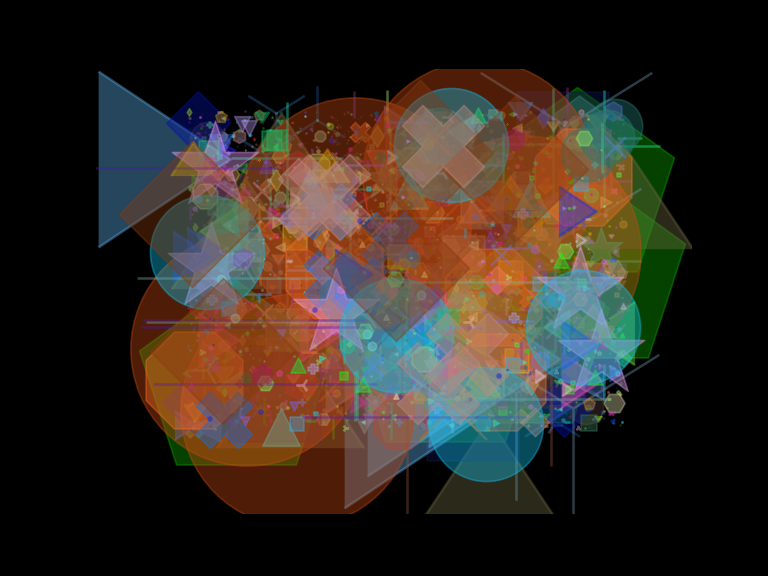

In [237]:
#What I hope it will look like:

markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', 
           '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', 
           '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 
           'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', 
           '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 
           3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase',
           9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', None: 'nothing', 
           ' ': 'nothing', '': 'nothing'}
plt.axis('off')
for _ in range(1000):
    a = np.random.randint(0,1000,5)
    b = np.random.randint(0,1000,5)
    rgba = [np.random.random() for _ in range(4)]
    color = np.array([rgba])
    marker = np.random.choice(list(markers.keys()))
    alpha = np.random.random()**2.5
    size = np.random.exponential()**5.3
    plt.scatter(a,b, alpha=0.4, marker=marker,
               color=color, s=size)

<IPython.core.display.Javascript object>


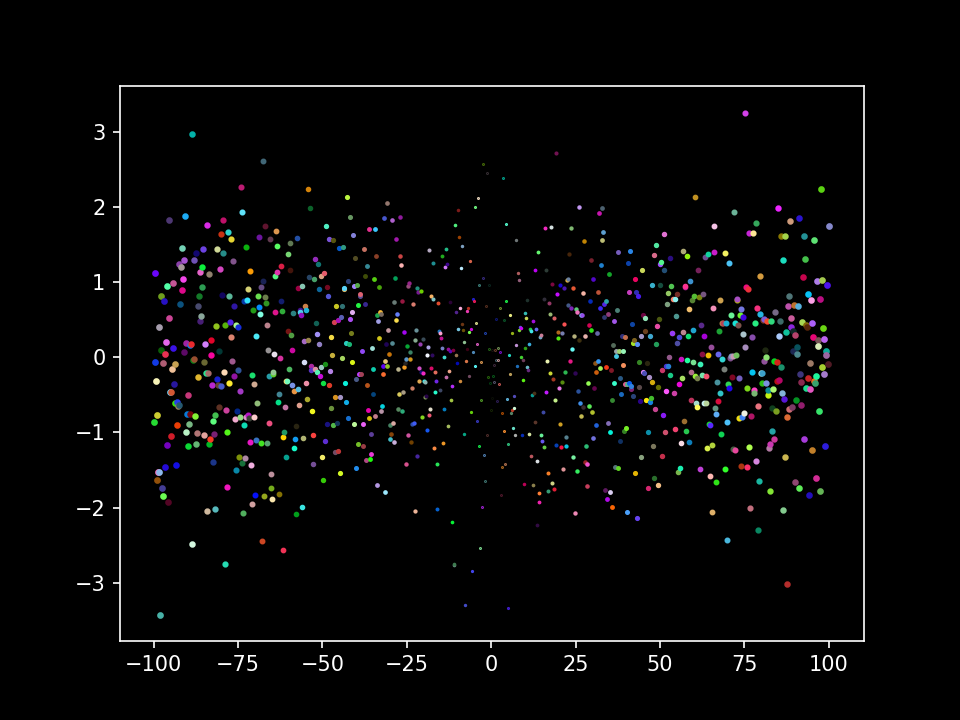

In [3]:
#some other cool visualizations:

xs = np.linspace(-100,100,1000)
for x in xs:
    rgb = [np.random.random() for _ in range(3)]
    color = np.array([rgb])
    plt.scatter(x,np.random.normal(),
               s = (np.abs(x))/20,
               c = color)

## Results

t

## Discussion

t